In [126]:
import pandas as pd
import numpy as np
import os
import re
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
movies = pd.read_csv('../data/movies.csv')

In [128]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [129]:
raw_genres = movies['genres'].unique()
genres = set(flatten([item.split('|') for item in raw_genres]))
genres.remove("(no genres listed)")
print('Genres', genres)

Genres {'Adventure', 'Horror', 'Crime', 'IMAX', 'Documentary', 'Fantasy', 'Thriller', 'Film-Noir', 'Children', 'War', 'Musical', 'Action', 'Drama', 'Comedy', 'Sci-Fi', 'Mystery', 'Animation', 'Romance', 'Western'}


In [130]:
genre_counts = movies.iloc[:, 4:].sum()  # Assuming genre columns start from the 5th column
genre_counts_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})

## Splitting up DF

In [131]:
def extractGenre(data, genre, column="genres"):
    solution = []
    for i in range(len(data)):
        if genre in data.loc[i, column]:
            solution.append(data.loc[i, :])
    return pd.DataFrame(solution)

In [132]:
genre_dataframes = {}


for genre in genres:
    genre_dataframes[genre] = extractGenre(movies, genre)
    
for genre, dataframe in genre_dataframes.items():
    globals()[f"{genre.lower()}_movies"] = dataframe
    dataframe.to_csv(f"../genre_data/{genre.lower()}_movies.csv", index=False)

# Splitting people up

In [133]:
ratings = pd.read_csv("../data/ratings.csv")

In [134]:
ratings_summary = ratings.groupby("userId").agg({"movieId": "count", 
                                                 "rating": "mean"})
ratings_summary = ratings_summary.rename(columns={"movieId": "reviewCount", "rating": "averageRating"})
ratings_summary


,reviewCount,averageRating
userId,,
1,232,4.366379
2,29,3.948276
3,39,2.435897
4,216,3.555556
5,44,3.636364
...,...,...
606,1115,3.657399
607,187,3.786096
608,831,3.134176


In [135]:
def summarize_by_genre(genre_df, data=ratings):
    merged_data = data.merge(genre_df, how="inner", on="movieId")

    # Group by userId and calculate average ratings and associated movieId
    summary_df = merged_data.groupby('userId').agg({
        'rating': 'mean',
        'movieId': 'count'
    }).reset_index()
    return summary_df

In [136]:
genre_by_user = {}
movies_per_genre = {}
mean_ratings_per_genre= {}

for genre in genres:
    summary_df = summarize_by_genre(globals()[f"{genre.lower()}_movies"], ratings)
    mean_ratings_per_genre[genre] = np.mean(summary_df['rating'])
    summary_df = summary_df.merge(ratings_summary, how = "inner", on = "userId")
    summary_df = summary_df.rename(columns={"movieId": "genreCount"})
    summary_df["percentGenre"] = summary_df["genreCount"]/summary_df["reviewCount"]
    
    genre_by_user[genre] = summary_df

In [137]:
mean_ratings_per_genre

{'Adventure': 3.617521194731765,
 'Horror': 3.455338485936204,
 'Crime': 3.757938820879007,
 'IMAX': 3.8061408019111314,
 'Documentary': 3.7799615021361586,
 'Fantasy': 3.5705128195223272,
 'Thriller': 3.62419746773377,
 'Film-Noir': 3.849600472824732,
 'Children': 3.4898310282002782,
 'War': 3.8705579742190888,
 'Musical': 3.589816616926097,
 'Action': 3.556514585960149,
 'Drama': 3.756815424339515,
 'Comedy': 3.567905248227137,
 'Sci-Fi': 3.532337408445801,
 'Mystery': 3.7594031626100612,
 'Animation': 3.6399358289826567,
 'Romance': 3.638772747176243,
 'Western': 3.642497003728455}

In [138]:
for genre, dataframe in genre_by_user.items():
    globals()[f"{genre.lower()}_users"] = dataframe
    dataframe.to_csv(f"../genre_data/{genre.lower()}_users.csv", index=False)

## Genre Analysis

In [139]:
movies = pd.read_csv('../data/movies.csv')
raw_genres = movies['genres'].unique()
genres = set(flatten([item.split('|') for item in raw_genres]))
genres.remove("(no genres listed)")

In [140]:
for genre in genres:
    print(f"{genre.lower()}_users.csv")

adventure_users.csv
horror_users.csv
crime_users.csv
imax_users.csv
documentary_users.csv
fantasy_users.csv
thriller_users.csv
film-noir_users.csv
children_users.csv
war_users.csv
musical_users.csv
action_users.csv
drama_users.csv
comedy_users.csv
sci-fi_users.csv
mystery_users.csv
animation_users.csv
romance_users.csv
western_users.csv


In [141]:
genre_dataframes = {}

for genre in genres:
    filename = f"../genre_data/{genre.lower()}_users.csv"
    genre_dataframes[genre] = pd.read_csv(filename)

Using formula $tanh(\frac{P_g * R_g * \ln(C_g)}{2})$

Where $P_g$ is the percentage of movies watched in Genre, $R_g$ is the averaging rating in the genre, and $C_g$ is the count of the movies watch in total.

In [142]:
user_id = ratings_summary.index
user_score = pd.DataFrame(user_id)

for genre, dataframe in genre_dataframes.items():
    df_copy = pd.DataFrame(dataframe["userId"].copy(), columns = ["userId"])
    df_copy[genre] = np.tanh(dataframe["percentGenre"] * dataframe["rating"] * np.log(dataframe["genreCount"])/np.log(np.exp(3)))
    user_score = user_score.merge(df_copy, how = "left", on = "userId")
    
    

In [143]:
user_score

,userId,Adventure,Horror,Crime,IMAX,Documentary,Fantasy,Thriller,Film-Noir,Children,War,Musical,Action,Drama,Comedy,Sci-Fi,Mystery,Animation,Romance,Western
0,1,0.983045,0.235658,0.790210,NaN,NaN,0.806672,0.864969,0.000000,0.772182,0.413374,0.427994,0.987007,0.953344,0.978193,0.714207,0.301767,0.577016,0.481005,0.083679
1,2,0.156549,0.000000,0.763989,0.234566,0.162702,NaN,0.752746,NaN,NaN,0.000000,NaN,0.833333,0.973191,0.555478,0.242081,0.063652,NaN,0.000000,0.000000
2,3,0.547529,0.582665,0.005924,NaN,NaN,0.158607,0.448099,NaN,0.034376,0.034376,0.000000,0.810266,0.276943,0.167426,0.897299,0.000000,0.023693,0.034376,NaN
3,4,0.501137,0.036353,0.480685,0.000000,0.008557,0.307763,0.639797,0.034216,0.134213,0.074933,0.267191,0.390419,0.995853,0.989372,0.129647,0.368856,0.066264,0.842044,0.134213
4,5,0.388122,0.000000,0.699312,0.091296,NaN,0.403239,0.487412,NaN,0.548259,0.083037,0.261986,0.435025,0.980741,0.788255,0.026250,0.000000,0.338965,0.549483,0.031496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0.645959,0.202689,0.611007,0.040593,0.009142,0.444080,0.804094,0.018958,0.194132,0.298270,0.183433,0.616890,0.999936,0.991211,0.351417,0.434350,0.172569,0.981293,0.049086
606,607,0.785103,0.722379,0.540681,0.000000,NaN,0.385941,0.950725,NaN,0.328509,0.079677,0.051594,0.966946,0.988680,0.863566,0.633574,0.379070,0.063791,0.545699,0.009884
607,608,0.838379,0.530526,0.783547,0.047808,0.012936,0.557412,0.966861,0.008341,0.370348,0.080141,0.126942,0.969330,0.974540,0.979630,0.811069,0.393646,0.268897,0.517125,0.027886
608,609,0.580892,0.043684,0.326568,0.000000,0.037450,0.000000,0.798211,NaN,0.037450,0.173088,NaN,0.625805,0.935120,0.382689,0.214126,NaN,0.000000,0.227917,0.000000


In [144]:
user_score_adj = user_score.iloc[:,1:].map(lambda x: 1 if x > 0.7 else (0 if not pd.isna(x) else 0))

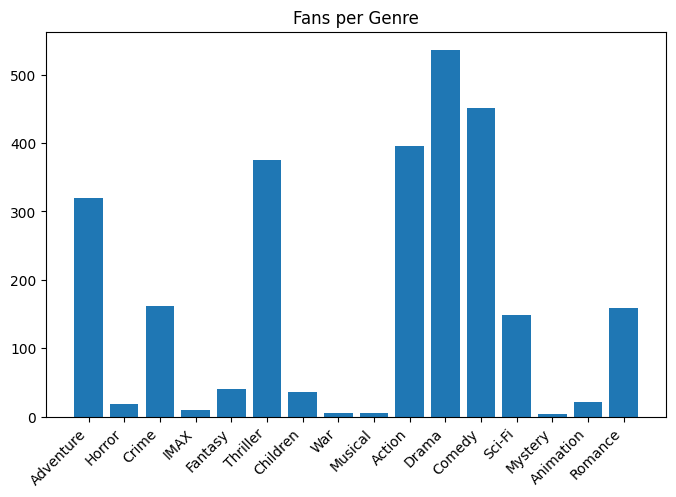

In [145]:
column_sums = user_score_adj.sum()
column_sums = column_sums.loc[column_sums != 0]

plt.figure(figsize=(8, 5))
plt.bar(x = column_sums.index, height = column_sums)
plt.title('Fans per Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

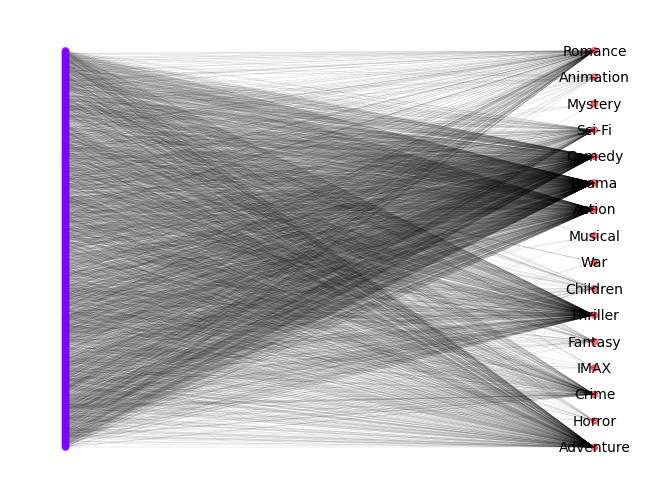

In [146]:
B = nx.Graph()

# Add nodes from rows (index) and columns
B.add_nodes_from(user_score_adj.index, bipartite=0)
B.add_nodes_from(user_score_adj.columns, bipartite=1)

# Add edges based on the non-zero entries in the adjacency matrix
for row_index, row in user_score_adj.iterrows():
    for col_index, value in row.items():
        if value != 0:
            B.add_edge(row_index, col_index, weight=value)

# Find connected components in the bipartite graph
components = list(nx.connected_components(B))

# Select the largest connected component
largest_component = max(components, key=len)

# Create a subgraph containing only the largest connected component
largest_component_graph = B.subgraph(largest_component)

# Assign colors to nodes based on bipartite sets
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use a different layout (spring layout in this case)
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use the bipartite layout
pos = nx.bipartite_layout(largest_component_graph, user_score_adj.index)

# Draw the largest connected component using the selected layout
nx.draw(largest_component_graph, pos, with_labels=False, font_weight='bold', node_size=20, font_size=10, width=0.1, node_color=colors, cmap=plt.cm.rainbow, alpha=0.5)

# Add labels for genre nodes
genre_labels = {node: node for node in user_score_adj.columns if node in largest_component_graph.nodes}

nx.draw_networkx_labels(largest_component_graph, pos, labels=genre_labels, font_color='black', font_size=10)

plt.show()

In [147]:
len(largest_component_graph.nodes())

622

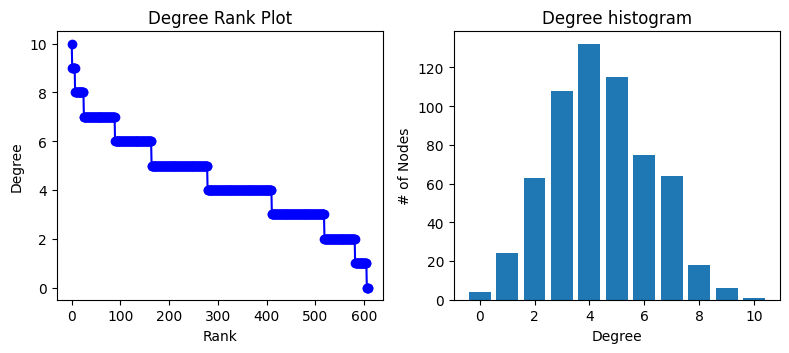

In [148]:
set1_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0} # Example, adjust according to your graph's attributes

# Now calculate degree sequence only for set 1 nodes
degree_sequence = sorted((d for n, d in B.degree(set1_nodes)), reverse=True)

dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

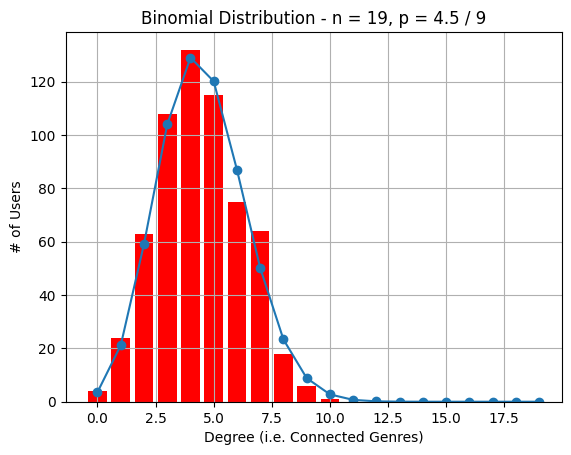

In [149]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, binom

# Number of trials
n = 19
# Probability of success, calculated from the expectation of 4 successes out of 19 trials
p = 4.5 / 19

# Generate a range of possible number of successes
x = np.arange(0, n+1)

# Calculate the PMF for the binomial distribution
pmf = binom.pmf(x, n, p) * 610

# Plot the PMF as a line chart with markers
plt.plot(x, pmf, marker='o')
plt.xlabel('Degree (i.e. Connected Genres)')
plt.ylabel('# of Users')
plt.title('Binomial Distribution - n = 19, p = 4.5 / 9')
plt.grid(True)

plt.bar(*np.unique(degree_sequence, return_counts=True), color = "red")

plt.grid(True)
plt.show()

## New Formula

In [150]:
user_id = ratings_summary.index
user_score = pd.DataFrame(user_id)

for genre, dataframe in genre_dataframes.items():
    df_copy = pd.DataFrame(dataframe["userId"].copy(), columns = ["userId"])

    df_copy[genre] = (dataframe["rating"]-dataframe["averageRating"])* (dataframe["reviewCount"]> 10)
    user_score = user_score.merge(df_copy, how = "left", on = "userId")

In [151]:
user_score

,userId,Adventure,Horror,Crime,IMAX,Documentary,Fantasy,Thriller,Film-Noir,Children,War,Musical,Action,Drama,Comedy,Sci-Fi,Mystery,Animation,Romance,Western
0,1,0.021856,-0.895791,-0.010824,NaN,NaN,-0.068507,-0.220925,0.633621,0.181240,0.133621,0.315439,-0.044157,0.163032,-0.089271,-0.141379,-0.199713,0.323276,-0.058687,-0.080665
1,2,0.218391,-0.948276,-0.148276,-0.198276,0.385057,NaN,-0.248276,NaN,NaN,0.551724,NaN,0.006270,-0.065923,0.051724,-0.073276,0.051724,NaN,0.551724,-0.448276
2,3,0.291375,2.251603,-1.935897,NaN,NaN,0.939103,1.706960,NaN,-1.935897,-1.935897,-1.935897,1.135531,-1.685897,-1.435897,1.764103,2.564103,-1.935897,-1.935897,NaN
3,4,0.099617,0.694444,0.259259,-0.555556,0.444444,0.128655,-0.002924,0.444444,0.244444,0.015873,0.444444,-0.235556,-0.072222,-0.045940,-0.722222,-0.077295,0.444444,-0.176245,0.244444
4,5,-0.386364,-0.636364,0.196970,0.030303,NaN,0.506494,-0.080808,NaN,0.474747,-0.303030,0.763636,-0.525253,0.163636,-0.169697,-1.136364,0.363636,0.696970,-0.545455,-0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,-0.153998,-0.311245,-0.003264,-0.594899,0.142601,-0.059461,-0.132273,0.155101,-0.208420,0.134909,0.069874,-0.478591,0.130567,-0.092078,-0.100437,0.133810,0.056887,0.083446,-0.245634
606,607,-0.319430,0.328189,0.028719,1.213904,NaN,-0.214668,0.328658,NaN,-0.365044,0.380570,-0.186096,-0.063874,0.226099,-0.458824,-0.536096,0.860963,-0.452763,-0.268855,0.213904
607,608,0.086819,0.185412,0.478838,0.865824,-0.134176,-0.134176,0.402504,0.615824,-0.673948,0.444772,-0.376600,0.196149,0.303324,-0.397556,0.162231,0.416549,-0.015994,-0.247383,-0.497812
608,609,-0.070270,0.229730,0.229730,-0.270270,-0.270270,-0.270270,0.015444,NaN,-0.270270,0.229730,NaN,-0.179361,0.098151,0.015444,-0.270270,NaN,-0.270270,-0.070270,0.729730


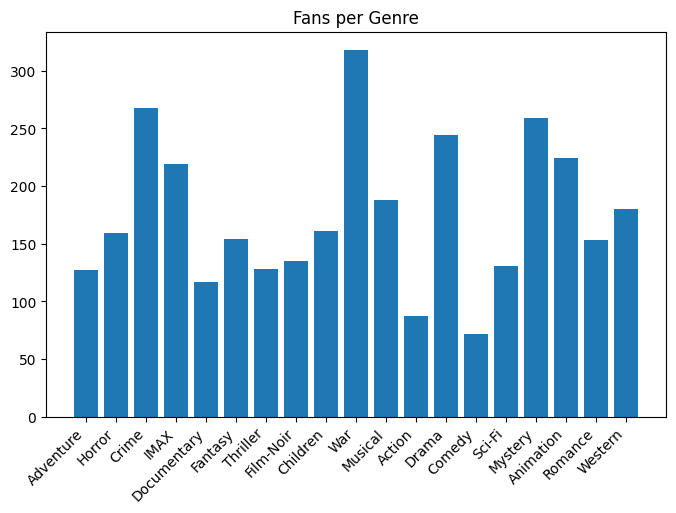

In [152]:
user_score_adj = user_score.iloc[:,1:].map(lambda x: 1 if x > 0.15 else (0 if not pd.isna(x) else 0))

column_sums = user_score_adj.sum()
column_sums = column_sums.loc[column_sums != 0]

plt.figure(figsize=(8, 5))
plt.bar(x = column_sums.index, height = column_sums)
plt.title('Fans per Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

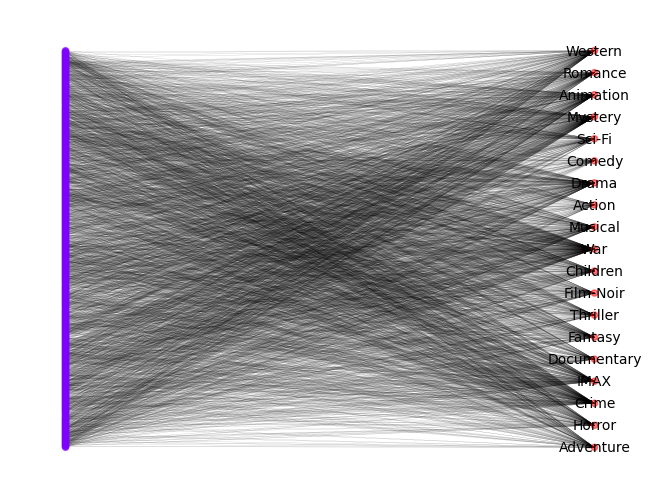

In [153]:
B = nx.Graph()

# Add nodes from rows (index) and columns
B.add_nodes_from(user_score_adj.index, bipartite=0)
B.add_nodes_from(user_score_adj.columns, bipartite=1)

# Add edges based on the non-zero entries in the adjacency matrix
for row_index, row in user_score_adj.iterrows():
    for col_index, value in row.items():
        if value != 0:
            B.add_edge(row_index, col_index, weight=value)

# Find connected components in the bipartite graph
components = list(nx.connected_components(B))

# Select the largest connected component
largest_component = max(components, key=len)

# Create a subgraph containing only the largest connected component
largest_component_graph = B.subgraph(largest_component)

# Assign colors to nodes based on bipartite sets
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use a different layout (spring layout in this case)
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use the bipartite layout
pos = nx.bipartite_layout(largest_component_graph, user_score_adj.index)

# Draw the largest connected component using the selected layout
nx.draw(largest_component_graph, pos, with_labels=False, font_weight='bold', node_size=20, font_size=10, width=0.1, node_color=colors, cmap=plt.cm.rainbow, alpha=0.5)

# Add labels for genre nodes
genre_labels = {node: node for node in user_score_adj.columns if node in largest_component_graph.nodes}

nx.draw_networkx_labels(largest_component_graph, pos, labels=genre_labels, font_color='black', font_size=10)

plt.show()

In [154]:
len(largest_component_graph.nodes())

624

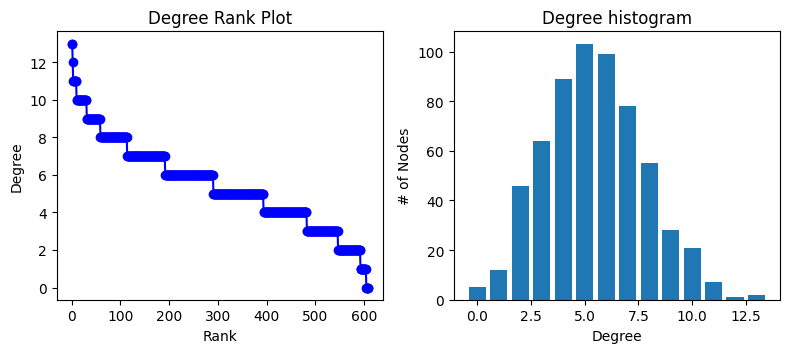

In [155]:
set1_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0} # Example, adjust according to your graph's attributes

# Now calculate degree sequence only for set 1 nodes
degree_sequence = sorted((d for n, d in B.degree(set1_nodes)), reverse=True)

dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

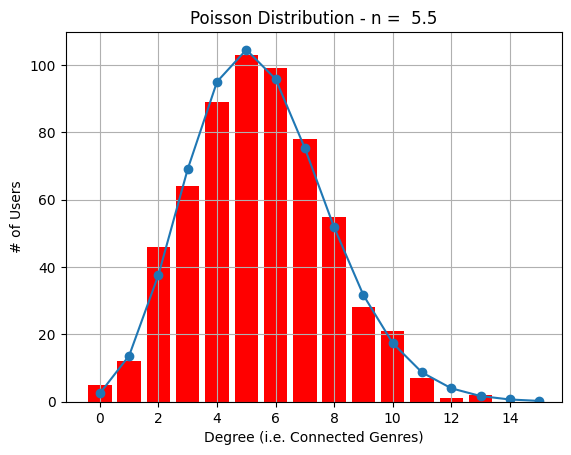

In [156]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, binom

# Number of trials
mu = 5.5

# Create a range of x values from 0 to 15 (or more if you like)
x = np.arange(0, 16)

# Calculate the PMF values for each x value
pmf = poisson.pmf(x, mu) * 610

# Plot the PMF as a line chart with markers
plt.plot(x, pmf, marker='o')
plt.xlabel('Degree (i.e. Connected Genres)')
plt.ylabel('# of Users')
plt.title('Poisson Distribution - n =  5.5')
plt.grid(True)

plt.bar(*np.unique(degree_sequence, return_counts=True), color = "red")

plt.grid(True)
plt.show()

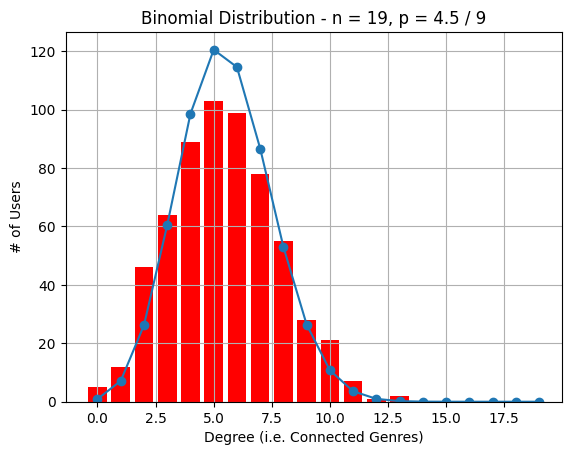

In [157]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, binom

# Number of trials
n = 19
# Probability of success, calculated from the expectation of 4 successes out of 19 trials
p = 5.5 / 19

# Generate a range of possible number of successes
x = np.arange(0, n+1)

# Calculate the PMF for the binomial distribution
pmf = binom.pmf(x, n, p) * 610

# Plot the PMF as a line chart with markers
plt.plot(x, pmf, marker='o')
plt.xlabel('Degree (i.e. Connected Genres)')
plt.ylabel('# of Users')
plt.title('Binomial Distribution - n = 19, p = 4.5 / 9')
plt.grid(True)

plt.bar(*np.unique(degree_sequence, return_counts=True), color = "red")

plt.grid(True)
plt.show()

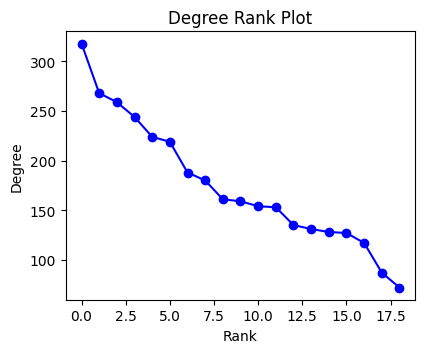

In [158]:
set1_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1} # Example, adjust according to your graph's attributes

# Now calculate degree sequence only for set 1 nodes
degree_sequence = sorted((d for n, d in B.degree(set1_nodes)), reverse=True)

dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

fig.tight_layout()
plt.show()

## Fixed 2 

In [159]:
user_id = ratings_summary.index
user_score = pd.DataFrame(user_id)

for genre, dataframe in genre_dataframes.items():
    df_copy = pd.DataFrame(dataframe["userId"].copy(), columns = ["userId"])

    df_copy[genre] = (dataframe["rating"]-dataframe["averageRating"])* (dataframe["reviewCount"]> 10)
    user_score = user_score.merge(df_copy, how = "left", on = "userId")

In [167]:
user_id = ratings_summary.index
user_score = pd.DataFrame(user_id)

for genre, dataframe in genre_dataframes.items():
    df_copy = pd.DataFrame(dataframe["userId"].copy(), columns = ["userId"])
    df_copy[genre] = dataframe["rating"]
    user_score = user_score.merge(df_copy, how = "left", on = "userId")
    
    

In [161]:
user_score

,userId,Adventure,Horror,Crime,IMAX,Documentary,Fantasy,Thriller,Film-Noir,Children,War,Musical,Action,Drama,Comedy,Sci-Fi,Mystery,Animation,Romance,Western
0,1,4.388235,3.470588,4.355556,NaN,NaN,4.297872,4.145455,5.0000,4.547619,4.500000,4.681818,4.322222,4.529412,4.277108,4.225000,4.166667,4.689655,4.307692,4.285714
1,2,4.166667,3.000000,3.800000,3.750000,4.333333,NaN,3.700000,NaN,NaN,4.500000,NaN,3.954545,3.882353,4.000000,3.875000,4.000000,NaN,4.500000,3.500000
2,3,2.727273,4.687500,0.500000,NaN,NaN,3.375000,4.142857,NaN,0.500000,0.500000,0.500000,3.571429,0.750000,1.000000,4.200000,5.000000,0.500000,0.500000,NaN
3,4,3.655172,4.250000,3.814815,3.000000,4.000000,3.684211,3.552632,4.0000,3.800000,3.571429,4.000000,3.320000,3.483333,3.509615,2.833333,3.478261,4.000000,3.379310,3.800000
4,5,3.250000,3.000000,3.833333,3.666667,NaN,4.142857,3.555556,NaN,4.111111,3.333333,4.400000,3.111111,3.800000,3.466667,2.500000,4.000000,4.333333,3.090909,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,3.503401,3.346154,3.654135,3.062500,3.800000,3.597938,3.525126,3.8125,3.448980,3.792308,3.727273,3.178808,3.787966,3.565321,3.556962,3.791209,3.714286,3.740845,3.411765
606,607,3.466667,4.114286,3.814815,5.000000,NaN,3.571429,4.114754,NaN,3.421053,4.166667,3.600000,3.722222,4.012195,3.327273,3.250000,4.647059,3.333333,3.517241,4.000000
607,608,3.220994,3.319588,3.613014,4.000000,3.000000,3.000000,3.536680,3.7500,2.460227,3.578947,2.757576,3.330325,3.437500,2.736620,3.296407,3.550725,3.118182,2.886792,2.636364
608,609,3.200000,3.500000,3.500000,3.000000,3.000000,3.000000,3.285714,NaN,3.000000,3.500000,NaN,3.090909,3.368421,3.285714,3.000000,NaN,3.000000,3.200000,4.000000


In [162]:
def convert_top_two(row):
    row = row[1:]
    # Find indices of the top two values
    top_two_indices = np.argsort(row)[-2:]
    # Create a new row of zeros
    new_row = np.zeros_like(row)
    # Set top two values to 1
    new_row[top_two_indices] = 1
    return pd.Series(new_row, index=row.index)

# Apply the function and ensure the output is compatible with the DataFrame structure
user_score = user_score.apply(lambda row: convert_top_two(row), axis=1)

user_score

/Users/joshuachen/anaconda3/envs/uni/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/Users/joshuachen/anaconda3/envs/uni/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/Users/joshuachen/anaconda3/envs/uni/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/Users/joshuachen/anaconda3/envs/uni/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Ser

,Adventure,Horror,Crime,IMAX,Documentary,Fantasy,Thriller,Film-Noir,Children,War,Musical,Action,Drama,Comedy,Sci-Fi,Mystery,Animation,Romance,Western
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [166]:
np.sum(user_score, axis =0)

Adventure       12.0
Horror          55.0
Crime           61.0
IMAX           111.0
Documentary     68.0
Fantasy         30.0
Thriller        64.0
Film-Noir      132.0
Children        67.0
War             66.0
Musical         36.0
Action          34.0
Drama           40.0
Comedy          57.0
Sci-Fi          56.0
Mystery         52.0
Animation       40.0
Romance         26.0
Western        211.0
dtype: float64

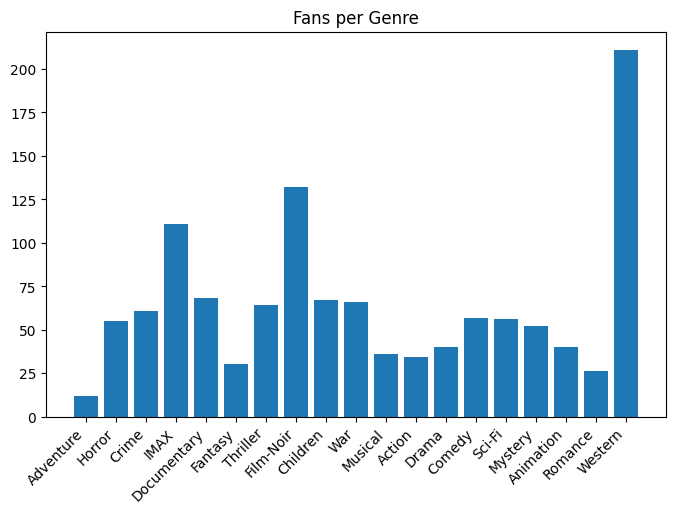

In [163]:
user_score_adj = user_score.iloc[:,:].map(lambda x: 1 if x > 0.15 else (0 if not pd.isna(x) else 0))

column_sums = user_score_adj.sum()
column_sums = column_sums.loc[column_sums != 0]

plt.figure(figsize=(8, 5))
plt.bar(x = column_sums.index, height = column_sums)
plt.title('Fans per Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

/Users/joshuachen/anaconda3/envs/uni/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


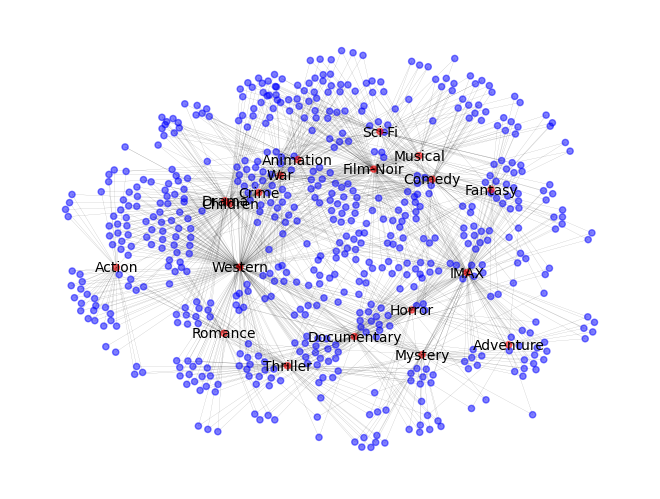

In [164]:
import networkx as nx
import matplotlib.pyplot as plt

B = nx.Graph()

# Assuming user_score_adj is your adjacency matrix/dataframe
# Add nodes from rows (index) and columns
B.add_nodes_from(user_score_adj.index, bipartite=0)
B.add_nodes_from(user_score_adj.columns, bipartite=1)

# Add edges based on the non-zero entries in the adjacency matrix
for row_index, row in user_score_adj.iterrows():
    for col_index, value in row.items():
        if value != 0:
            B.add_edge(row_index, col_index, weight=value)

# Assign colors to nodes based on bipartite sets
colors = ['blue' if node in user_score_adj.index else 'red' for node in B.nodes]

# Use the spring layout
pos = nx.spring_layout(B)  # This line is changed to use spring layout

# Draw the graph using the spring layout
nx.draw(B, pos, with_labels=False, font_weight='bold', node_size=20, font_size=10, width=0.1, node_color=colors, cmap=plt.cm.rainbow, alpha=0.5)

# Add labels for nodes in the 'columns' set (e.g., genres)
labels = {node: node for node in user_score_adj.columns if node in B.nodes}
nx.draw_networkx_labels(B, pos, labels=labels, font_color='black', font_size=10)

plt.show()
